In [63]:
import pickle

import arviz
import bambi
import matplotlib.pyplot as plt
import pandas as pd
import pymc3 as pm
import scipy.stats as ss

import wmfdata as wmf

In [17]:
wmf.charting.set_mpl_style()

In [19]:
user = pd.read_parquet("data/2021-06-24_experiment_user.parquet")

In [ ]:
user.head()

# Basic tests

In [30]:
control_user = user.query("experiment_group == 'control'")
trending_articles_user = user.query("experiment_group == 'trending-articles'")

In [31]:
print(f"Control mean session length: {round(control_user['mean_session_min'].mean(), 3)} min")
print(f"Trending articles mean session length: {round(trending_articles_user['mean_session_min'].mean(), 3)} min")

Control mean session length: 2.25 min
Trending articles mean session length: 2.591 min


In [32]:
ss.ttest_ind(control_user["mean_session_min"], trending_articles_user["mean_session_min"], equal_var=False)

Ttest_indResult(statistic=-7.303528391500998, pvalue=2.8555907171721905e-13)

In [33]:
print(f"Control mean sessions: {round(control_user['sessions'].mean(), 3)}")
print(f"Trending articles mean sessions: {round(trending_articles_user['sessions'].mean(), 3)}")

Control mean sessions: 1.669
Trending articles mean sessions: 1.699


Interesting that there's a divergence between the two types of tests.

In [34]:
ss.ttest_ind(control_user["sessions"], trending_articles_user["sessions"], equal_var=False)

Ttest_indResult(statistic=-1.6214581611923018, pvalue=0.10492724488287576)

In [35]:
ss.mannwhitneyu(control_user["sessions"], trending_articles_user["sessions"])

MannwhitneyuResult(statistic=199987103.0, pvalue=0.0025659611930935666)

# Session length model

## Attempt 2

In [ ]:
session_length_model_2 = bambi.Model(
    "mean_session_min ~ days_in_experiment + country + experiment_group + (experiment_group|country)",
    user,
    family="gaussian"
)

session_length_model_2.build()

In [ ]:
with session_length_model_2.backend.model:
    custom_step = pm.step_methods.hmc.nuts.NUTS(target_accept=0.98, max_treedepth=15)

session_length_results_2 = session_length_model_2.fit(step=custom_step)

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mean_session_min_sigma, experiment_group[trending-articles]|country_offset, experiment_group[trending-articles]|country_sigma, 1|country_offset, 1|country_sigma, experiment_group, country, days_in_experiment, Intercept]


In [59]:
session_length_results_2.to_netcdf("data/session_length_results_2.nc");

In [ ]:
session_length_results_2 = arviz.InferenceData.from_netcdf('data/session_length_results_2.nc')

In [61]:
session_length_results_2["sample_stats"]["diverging"].sum()

<xarray.DataArray 'diverging' ()>
array(5)

In [55]:
pm.summary(session_length_results_2).round(2)

mean    sd  hdi_3%  \
Intercept                                          3.30  3.31   -3.50   
days_in_experiment                                 0.01  0.00    0.01   
country[0]                                        -1.95  4.82  -11.43   
country[1]                                        -1.24  4.71  -10.23   
country[2]                                        -0.26  5.01  -10.11   
experiment_group                                   0.44  0.38   -0.15   
1|country_sigma                                    3.78  3.02    0.00   
1|country[0]                                       0.33  3.31   -6.54   
1|country[1]                                      -0.12  4.04   -9.10   
1|country[2]                                      -0.06  3.93   -7.53   
1|country[3]                                      -0.00  4.23   -7.68   
experiment_group[trending-articles]|country_sigma  0.56  0.58    0.10   
experiment_group[trending-articles]|country[0]     0.05  0.39   -0.57   
experiment_group[trending-articles]|country[1]    -0.30  0.38   -0.93   
experiment_group[trending-articles]|country[2]    -0.05  0.39   -0.69   
experiment_group[trending-articles]|country[3]     0.34  0.39   -0.27   
mean_session_min_sigma                             4.56  0.02    4.53   

                                                   hdi_97%  mcse_mean  \
Intercept                                             9.93       0.08   
days_in_experiment                                    0.01       0.00   
country[0]                                            8.04       0.11   
country[1]                                            8.60       0.11   
country[2]                                           10.88       0.12   
experiment_group                                      1.10       0.01   
1|country_sigma                                       9.28       0.08   
1|country[0]                                          6.96       0.08   
1|country[1]                                          7.22       0.07   
1|country[2]                                          8.09       0.08   
1|country[3]                                          9.44       0.08   
experiment_group[trending-articles]|country_sigma     1.39       0.02   
experiment_group[trending-articles]|country[0]        0.70       0.01   
experiment_group[trending-articles]|country[1]        0.32       0.01   
experiment_group[trending-articles]|country[2]        0.57       0.01   
experiment_group[trending-articles]|country[3]        1.00       0.01   
mean_session_min_sigma                                4.59       0.00   

                                                   mcse_sd  ess_mean  ess_sd  \
Intercept                                             0.06    1570.0  1570.0   
days_in_experiment                                    0.00    5194.0  4932.0   
country[0]                                            0.08    2027.0  1821.0   
country[1]                                            0.09    1951.0  1513.0   
country[2]                                            0.10    1598.0  1312.0   
experiment_group                                      0.01    1147.0   544.0   
1|country_sigma                                       0.06    1337.0  1337.0   
1|country[0]                                          0.06    1571.0  1484.0   
1|country[1]                                          0.07    2999.0  1899.0   
1|country[2]                                          0.06    2550.0  1837.0   
1|country[3]                                          0.08    2457.0  1521.0   
experiment_group[trending-articles]|country_sigma     0.02     558.0   558.0   
experiment_group[trending-articles]|country[0]        0.01    1170.0   481.0   
experiment_group[trending-articles]|country[1]        0.01    1179.0   498.0   
experiment_group[trending-articles]|country[2]        0.01    1167.0   472.0   
experiment_group[trending-articles]|country[3]        0.01    1179.0   536.0   
mean_session_min_sigma                                0.00   

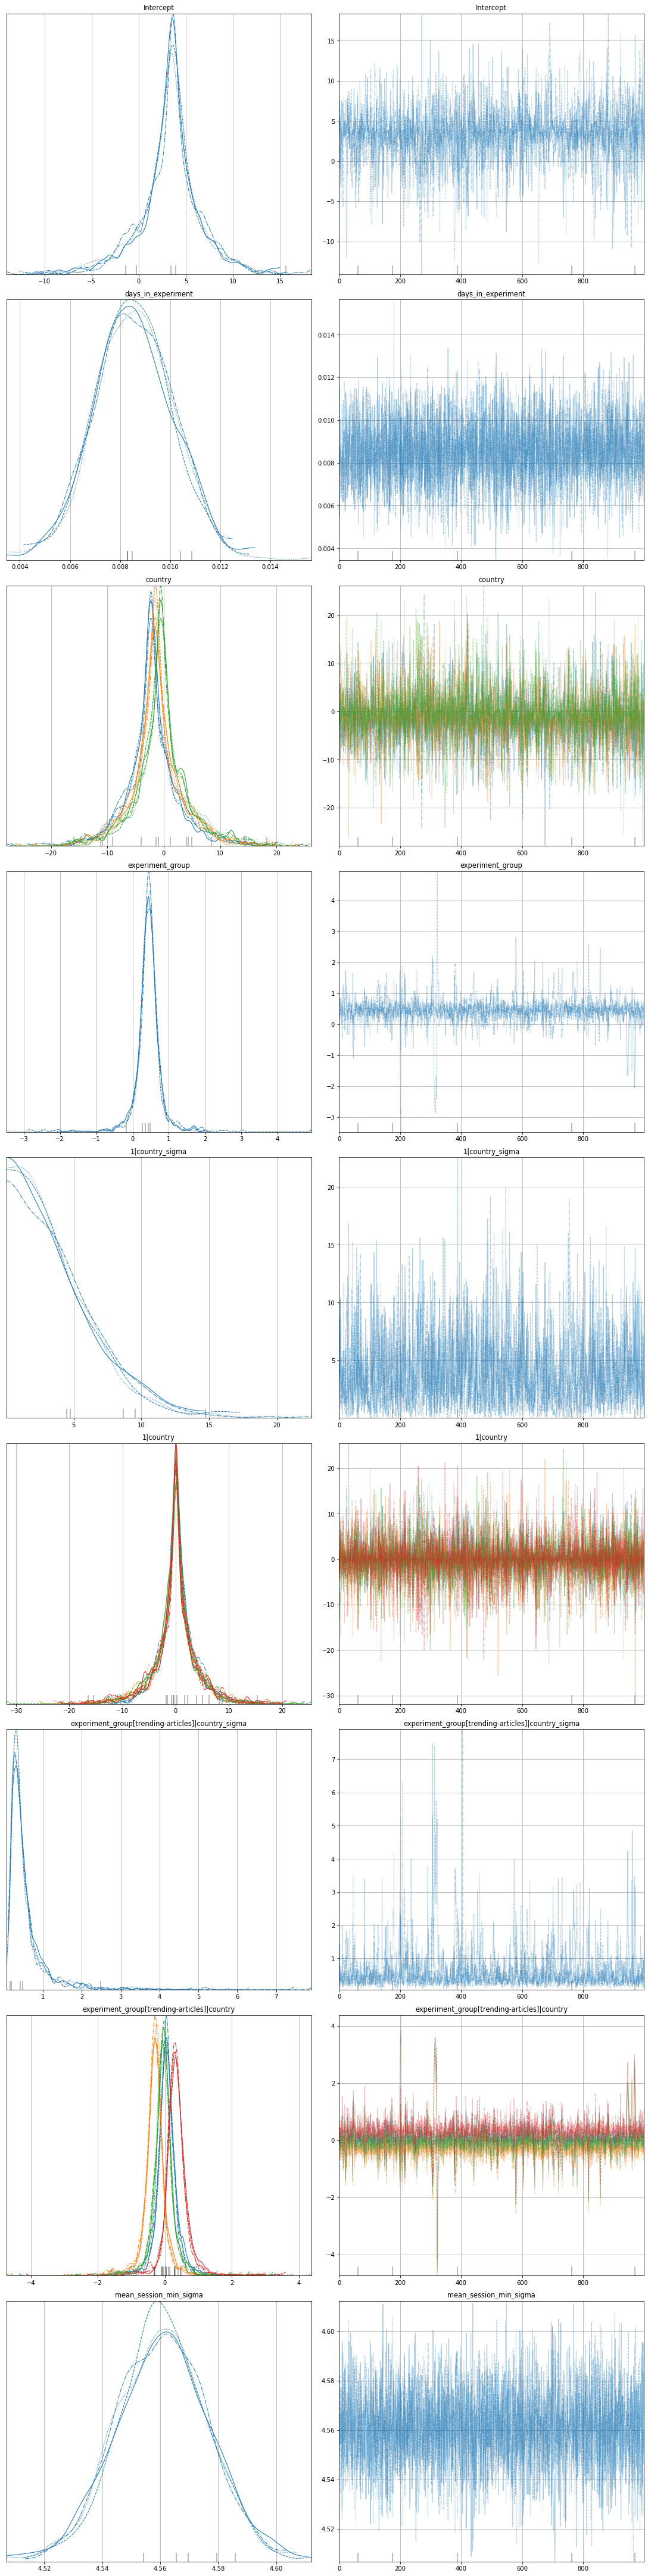

In [56]:
arviz.plot_trace(
    session_length_results_2
)

fig = plt.gcf()
fig.set_size_inches(15, 60);

# Session count model

## Attempt 1

In [10]:
model = bambi.Model(
    "sessions ~ lg_min_in_experiment + country + experiment_group + (experiment_group|country)",
    user,
    family="poisson"
)

results = model.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [experiment_group[trending-articles]|country_offset, experiment_group[trending-articles]|country_sigma, 1|country_offset, 1|country_sigma, experiment_group, country, lg_min_in_experiment, Intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5684 seconds.
There were 126 divergences after tuning. Increase `target_accept` or reparameterize.
There were 127 divergences after tuning. Increase `target_accept` or reparameterize.
There were 226 divergences after tuning. Increase `target_accept` or reparameterize.
There were 825 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.06481254239845938, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


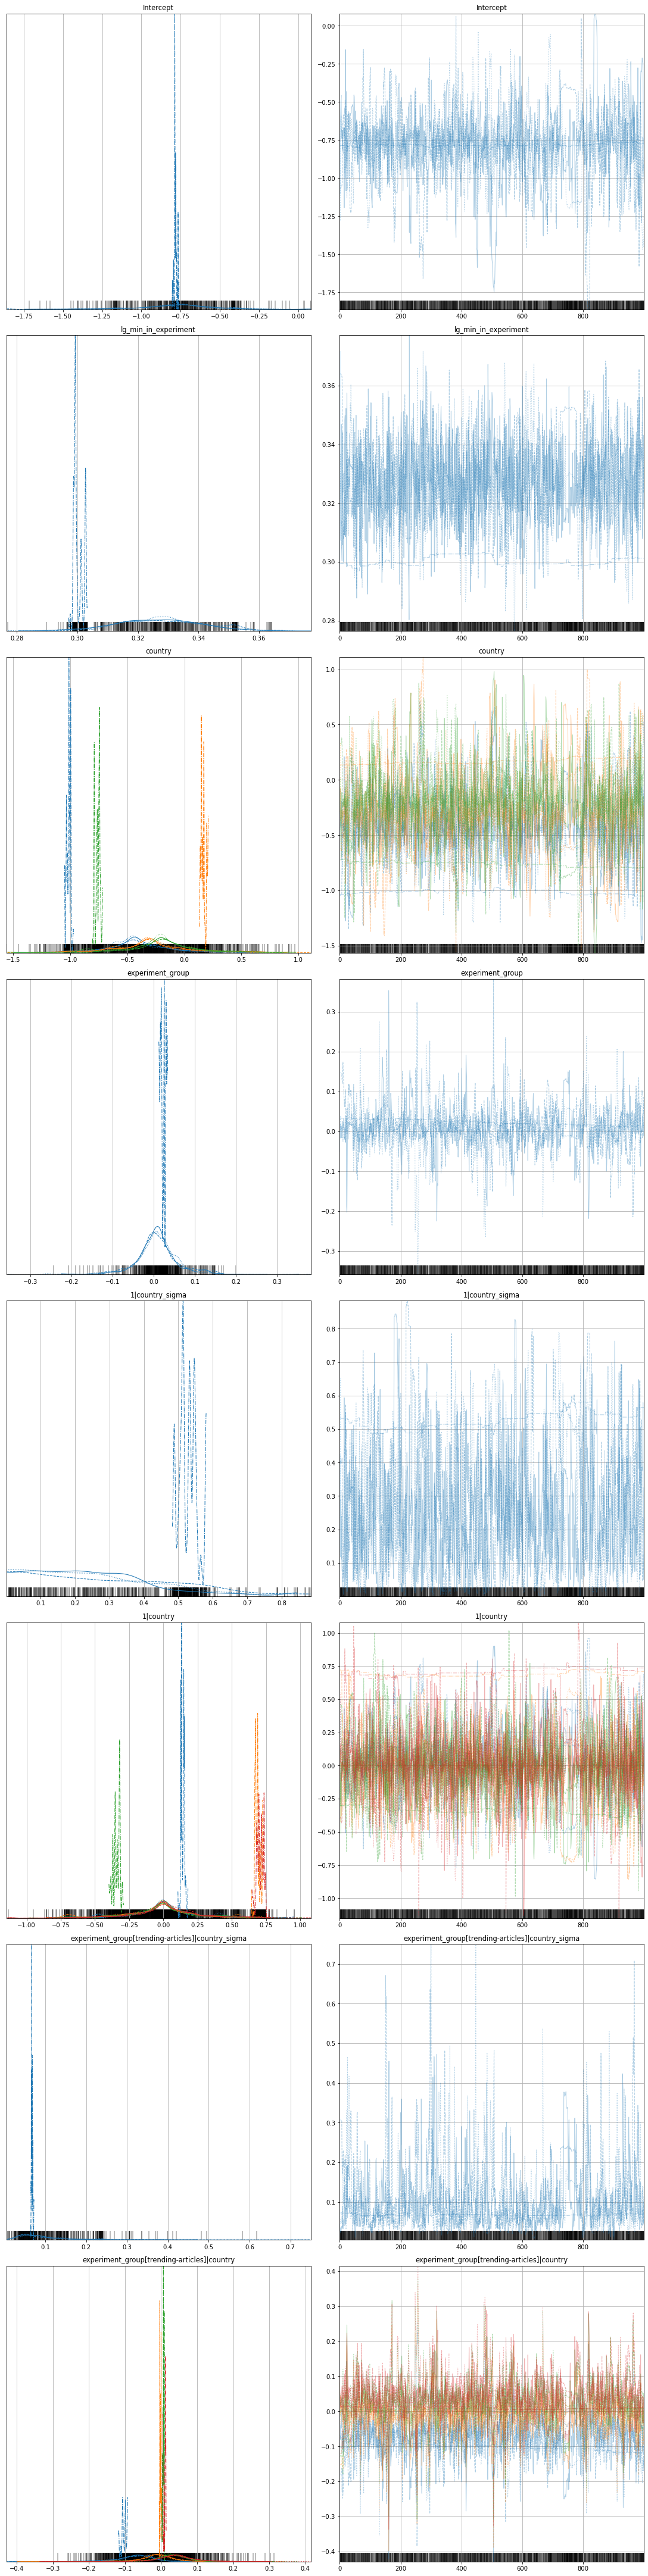

In [15]:
arviz.plot_trace(
    results
)

fig = plt.gcf()
fig.set_size_inches(15, 60);

## Attempt 2

In [9]:
sessions_model_2 = bambi.Model(
    "sessions ~ lg_min_in_experiment + country + experiment_group + (experiment_group|country)",
    user,
    family="poisson"
)

sessions_model_2.build()

with sessions_model_2.backend.model:
    custom_step = pm.step_methods.hmc.nuts.NUTS(target_accept=0.95)

sessions_results_2 = sessions_model_2.fit(step=custom_step)

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [experiment_group[trending-articles]|country_offset, experiment_group[trending-articles]|country_sigma, 1|country_offset, 1|country_sigma, experiment_group, country, lg_min_in_experiment, Intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 27168 seconds.
There were 46 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 33 divergences after tuning. Increase `target_accept` or reparameterize.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 39 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


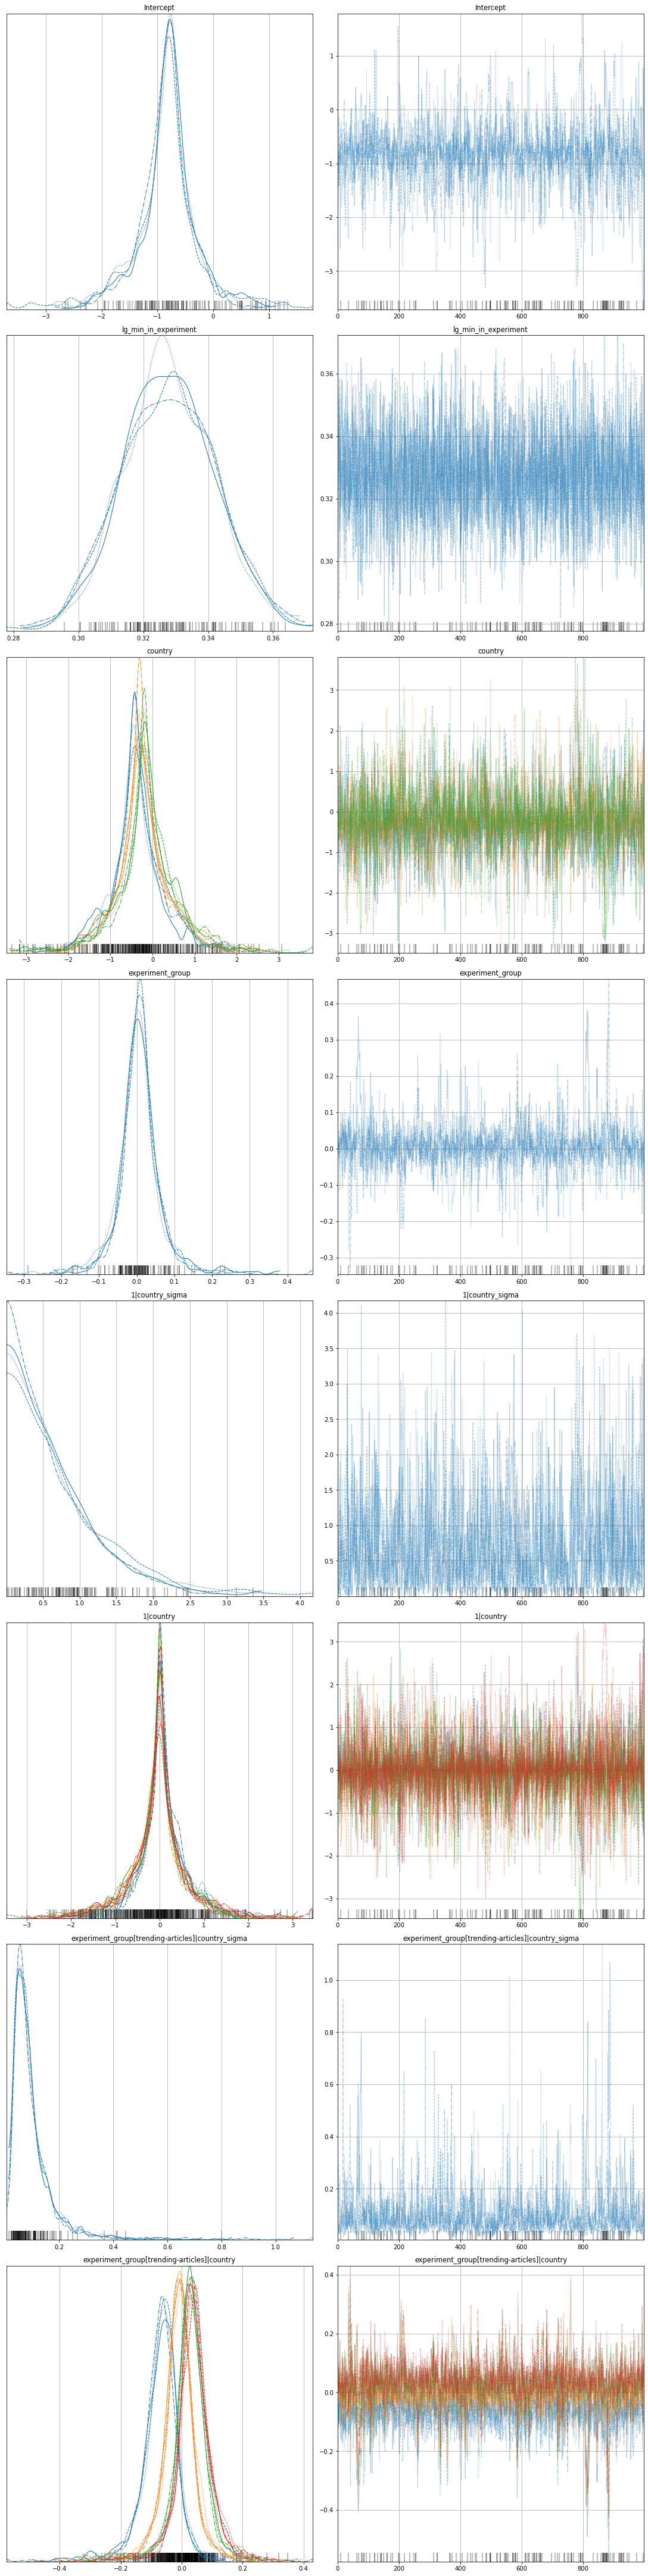

In [12]:
arviz.plot_trace(
    session_results_2
)

fig = plt.gcf()
fig.set_size_inches(15, 60);

In [37]:
session_results_2

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

In [38]:
pm.summary(session_results_2).round(2)

mean    sd  hdi_3%  \
Intercept                                         -0.84  0.56   -2.00   
lg_min_in_experiment                               0.33  0.01    0.30   
country[0]                                        -0.32  0.70   -1.82   
country[1]                                        -0.21  0.68   -1.55   
country[2]                                        -0.14  0.77   -1.62   
experiment_group                                   0.01  0.06   -0.10   
1|country_sigma                                    0.70  0.64    0.00   
1|country[0]                                       0.07  0.55   -1.06   
1|country[1]                                      -0.06  0.61   -1.60   
1|country[2]                                      -0.04  0.63   -1.22   
1|country[3]                                       0.00  0.68   -1.38   
experiment_group[trending-articles]|country_sigma  0.10  0.09    0.02   
experiment_group[trending-articles]|country[0]    -0.07  0.06   -0.19   
experiment_group[trending-articles]|country[1]    -0.01  0.06   -0.12   
experiment_group[trending-articles]|country[2]     0.03  0.06   -0.08   
experiment_group[trending-articles]|country[3]     0.04  0.06   -0.07   

                                                   hdi_97%  mcse_mean  \
Intercept                                             0.25       0.02   
lg_min_in_experiment                                  0.35       0.00   
country[0]                                            0.97       0.02   
country[1]                                            1.16       0.02   
country[2]                                            1.46       0.02   
experiment_group                                      0.12       0.00   
1|country_sigma                                       1.88       0.02   
1|country[0]                                          1.16       0.02   
1|country[1]                                          1.01       0.01   
1|country[2]                                          1.28       0.02   
1|country[3]                                          1.39       0.02   
experiment_group[trending-articles]|country_sigma     0.23       0.00   
experiment_group[trending-articles]|country[0]        0.04       0.00   
experiment_group[trending-articles]|country[1]        0.11       0.00   
experiment_group[trending-articles]|country[2]        0.15       0.00   
experiment_group[trending-articles]|country[3]        0.16       0.00   

                                                   mcse_sd  ess_mean  ess_sd  \
Intercept                                             0.02     885.0   721.0   
lg_min_in_experiment                                  0.00    4348.0  4304.0   
country[0]                                            0.01    1320.0  1185.0   
country[1]                                            0.01    1372.0  1164.0   
country[2]                                            0.02    1043.0   824.0   
experiment_group                                      0.00     727.0   634.0   
1|country_sigma                                       0.02     839.0   839.0   
1|country[0]                                          0.02     885.0   476.0   
1|country[1]                                          0.01    1757.0  1036.0   
1|country[2]                                          0.02    1570.0   475.0   
1|country[3]                                          0.02    1130.0   583.0   
experiment_group[trending-articles]|country_sigma     0.00     783.0   783.0   
experiment_group[trending-articles]|country[0]        0.00     772.0   565.0   
experiment_group[trending-articles]|country[1]        0.00     756.0   632.0   
experiment_group[trending-articles]|country[2]        0.00     780.0   780.0   
experiment_group[trending-articles]|country[3]        0.00     779.0   779.0   

                                                   ess_bulk  ess_tail  r_hat  
Intercept                                            1027.0    1018.0   1.00  
lg_min_in_experiment                            

In [ ]:
sessions_model_2 = bambi.Model(
    "sessions ~ lg_min_in_experiment + country + experiment_group + (experiment_group|country)",
    user,
    family="wald"
)

sessions_model_2.build()

# with sessions_model_2.backend.model:
#     custom_step = pm.step_methods.hmc.nuts.NUTS(target_accept=0.95)

session_results_2 = sessions_model_2.fit(step=custom_step)

# Minor caveats
* After the scheduled publication of recommendations on 2 June at 03:00 UTC, an infrastructure issue prevented new recommendations from being published (although the existing recommendations continued to be served to app users). The issue was fixed and updated set of recommendations were published on 4 June at 23:00 UTC, followed by scheduled updates as normal.